# 06. Ridge Model

**Mô hình:** Ridge Regression (L2 regularization)

**Thư viện:** sklearn.linear_model.Ridge

**Metrics:** RMSFE, MAPE

In [7]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os

# Machine learning libraries
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Add utils to path
sys.path.append(os.path.join('..', 'utils'))
from metrics import rmsfe, mape

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [8]:
# Load processed data
train_df = pd.read_csv('../data/processed/train_clean.csv')
test_df = pd.read_csv('../data/processed/test_clean.csv')

# Define target column
TARGET_COL = 'Core CPI'

# Prepare features and target
X_train = train_df.drop(columns=[TARGET_COL])
y_train = train_df[TARGET_COL].values

X_test = test_df.drop(columns=[TARGET_COL])
y_test = test_df[TARGET_COL].values

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nFeature names (first 10): {list(X_train.columns[:10])}")
print(f"\nTarget variable: {TARGET_COL}")
print(f"  Train range: [{y_train.min():.4f}, {y_train.max():.4f}]")
print(f"  Test range: [{y_test.min():.4f}, {y_test.max():.4f}]")

Training set: 112 samples, 190 features
Test set: 28 samples

Feature names (first 10): ['Fecha', 'Headline CPI_lag_1', 'Headline CPI_lag_2', 'Headline CPI_lag_3', 'Terms of Trade - Exports_lag_1', 'Terms of Trade - Exports_lag_2', 'Terms of Trade - Exports_lag_3', 'Terms of Trade - Imports_lag_1', 'Terms of Trade - Imports_lag_2', 'Terms of Trade - Imports_lag_3']

Target variable: Core CPI
  Train range: [0.0783, 0.4937]
  Test range: [0.3847, 0.7658]


Starting Grid Search for Ridge Regression...
Alpha values to test: [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
Cross-validation splits: 5 (Time Series)
Scoring metric: Negative RMSE

Fitting 5 folds for each of 10 candidates, totalling 50 fits

GRID SEARCH RESULTS
Best Alpha: 50.0
Best CV Score (neg RMSE): -0.089893
Best CV RMSE: 0.089893

All Hyperparameter Combinations:
   Alpha  Mean_RMSE  Std_RMSE  Rank
 50.0000   0.089893  0.046136     1
 10.0000   0.091356  0.036906     2
100.0000   0.094194  0.051373     3
  5.0000   0.099022  0.040059     4
  1.0000   0.124841  0.079019     5
  0.5000   0.134204  0.096185     6
  0.1000   0.145520  0.117540     7
  0.0100   0.148849  0.123901     8
  0.0010   0.149203  0.124580     9
  0.0001   0.149239  0.124648    10


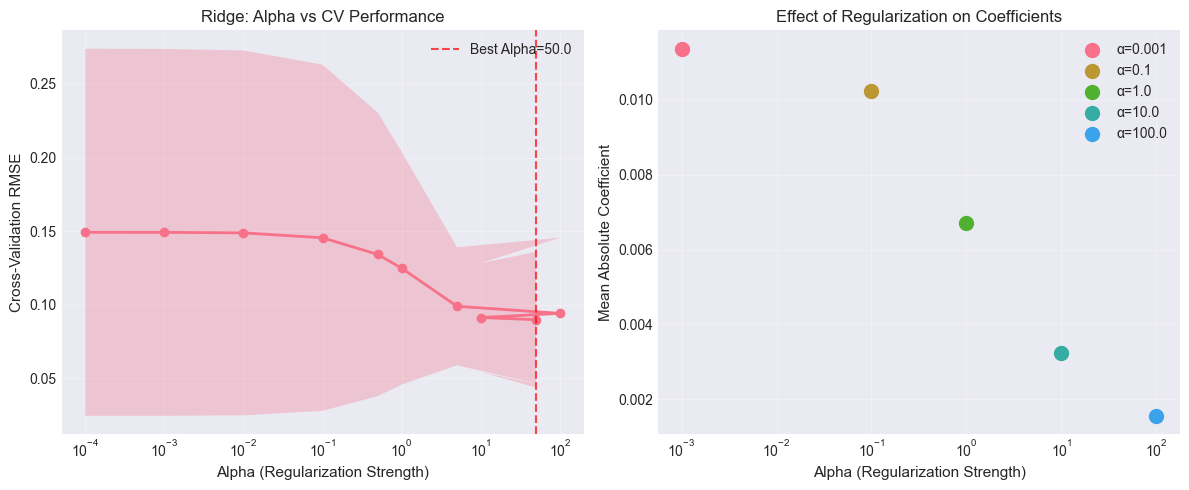


Top 15 Most Important Features (by coefficient magnitude):
                                                     Feature  Coefficient  Abs_Coefficient
                                          Headline CPI_lag_3     0.019194         0.019194
    Macroeconomic Expectations - Inflation (12 months)_lag_1     0.018903         0.018903
    Macroeconomic Expectations - Inflation (12 months)_lag_3     0.018888         0.018888
                                          Headline CPI_lag_2     0.018134         0.018134
    Macroeconomic Expectations - Inflation (12 months)_lag_2     0.018081         0.018081
                                          Headline CPI_lag_1     0.017443         0.017443
Macroeconomic Expectations - Exchange Rate (12 months)_lag_3    -0.011022         0.011022
Macroeconomic Expectations - Exchange Rate (12 months)_lag_2    -0.010203         0.010203
              Private Credit - MN - Mortgage (mill S/)_lag_1     0.009506         0.009506
Macroeconomic Expectations - E

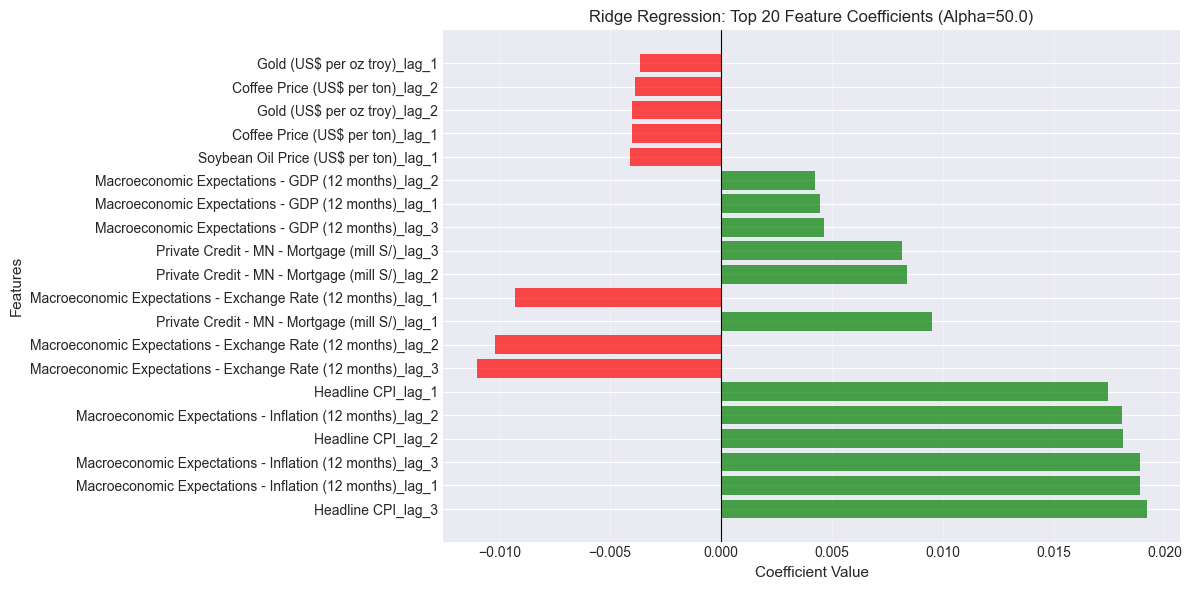


✓ Ridge model trained successfully with alpha=50.0


In [9]:
# Ridge Regression with GridSearchCV
"""
Ridge Regression (L2 Regularization)
Formula: minimize(||y - Xw||² + alpha * ||w||²)

Ridge adds L2 penalty to the loss function, which shrinks coefficients
but doesn't set them to zero (unlike LASSO). Good for handling multicollinearity.
"""

# Define Ridge model
ridge = Ridge(random_state=42, max_iter=10000)

# Define hyperparameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
}

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

print("Starting Grid Search for Ridge Regression...")
print(f"Alpha values to test: {param_grid['alpha']}")
print(f"Cross-validation splits: 5 (Time Series)")
print(f"Scoring metric: Negative RMSE\n")

# Grid Search
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Fit the model
# Drop date column if it exists
X_train_model = X_train.drop(columns=['Fecha'], errors='ignore')
X_test_model = X_test.drop(columns=['Fecha'], errors='ignore')

grid_search.fit(X_train_model, y_train)

# Get best model
best_ridge = grid_search.best_estimator_
best_alpha = grid_search.best_params_['alpha']

print("\n" + "="*70)
print("GRID SEARCH RESULTS")
print("="*70)
print(f"Best Alpha: {best_alpha}")
print(f"Best CV Score (neg RMSE): {grid_search.best_score_:.6f}")
print(f"Best CV RMSE: {-grid_search.best_score_:.6f}")
print("="*70)

# Display all results
results_df = pd.DataFrame(grid_search.cv_results_)
results_display = results_df[['param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']].copy()
results_display['mean_test_score'] = -results_display['mean_test_score']  # Convert to positive RMSE
results_display.columns = ['Alpha', 'Mean_RMSE', 'Std_RMSE', 'Rank']
results_display = results_display.sort_values('Rank')

print("\nAll Hyperparameter Combinations:")
print(results_display.to_string(index=False))

# Plot CV results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results_display['Alpha'], results_display['Mean_RMSE'], marker='o', linewidth=2)
plt.fill_between(results_display['Alpha'], 
                 results_display['Mean_RMSE'] - results_display['Std_RMSE'],
                 results_display['Mean_RMSE'] + results_display['Std_RMSE'],
                 alpha=0.3)
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)', fontsize=11)
plt.ylabel('Cross-Validation RMSE', fontsize=11)
plt.title('Ridge: Alpha vs CV Performance', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axvline(x=best_alpha, color='red', linestyle='--', alpha=0.7, label=f'Best Alpha={best_alpha}')
plt.legend()

plt.subplot(1, 2, 2)
# Show coefficient magnitude for different alphas
alphas_to_plot = [0.001, 0.1, 1.0, 10.0, 100.0]
for alpha_val in alphas_to_plot:
    if alpha_val in param_grid['alpha']:
        model = Ridge(alpha=alpha_val, random_state=42, max_iter=10000)
        model.fit(X_train_model, y_train)
        coef_magnitude = np.abs(model.coef_).mean()
        plt.scatter(alpha_val, coef_magnitude, s=100, label=f'α={alpha_val}')

plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)', fontsize=11)
plt.ylabel('Mean Absolute Coefficient', fontsize=11)
plt.title('Effect of Regularization on Coefficients', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('../results/figures/ridge_gridsearch.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze feature importance (coefficient magnitude)
feature_importance = pd.DataFrame({
    'Feature': X_train_model.columns,
    'Coefficient': best_ridge.coef_
})
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print(f"\nTop 15 Most Important Features (by coefficient magnitude):")
print(feature_importance.head(15).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(12, 6))
top_features = feature_importance.head(20)
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value', fontsize=11)
plt.ylabel('Features', fontsize=11)
plt.title(f'Ridge Regression: Top 20 Feature Coefficients (Alpha={best_alpha})', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../results/figures/ridge_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Ridge model trained successfully with alpha={best_alpha}")

RIDGE REGRESSION - EVALUATION RESULTS
Model: Ridge Regression (L2 Regularization)
Best Alpha: 50.0

Test Set Performance:
  RMSFE: 0.092964
  MAPE:  13.6997%

Residuals Summary Statistics:
  Mean:     0.036679
  Std Dev:  0.085423
  Min:      -0.101844
  Max:      0.194198
  Median:   0.034971


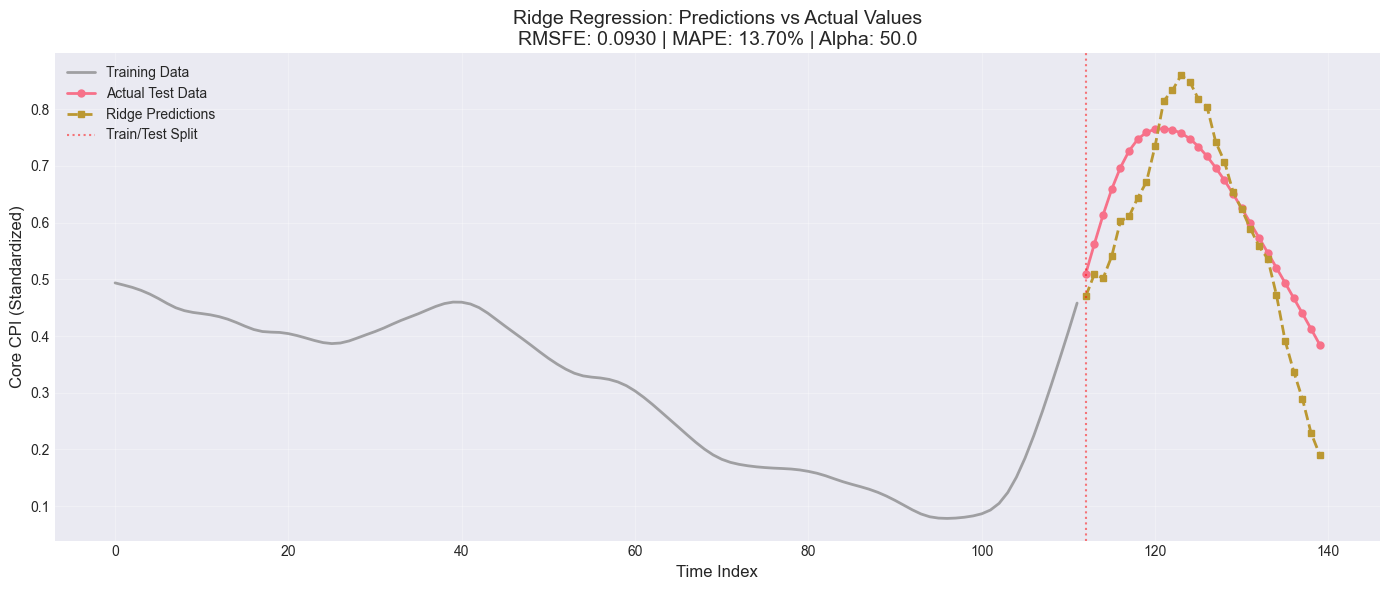

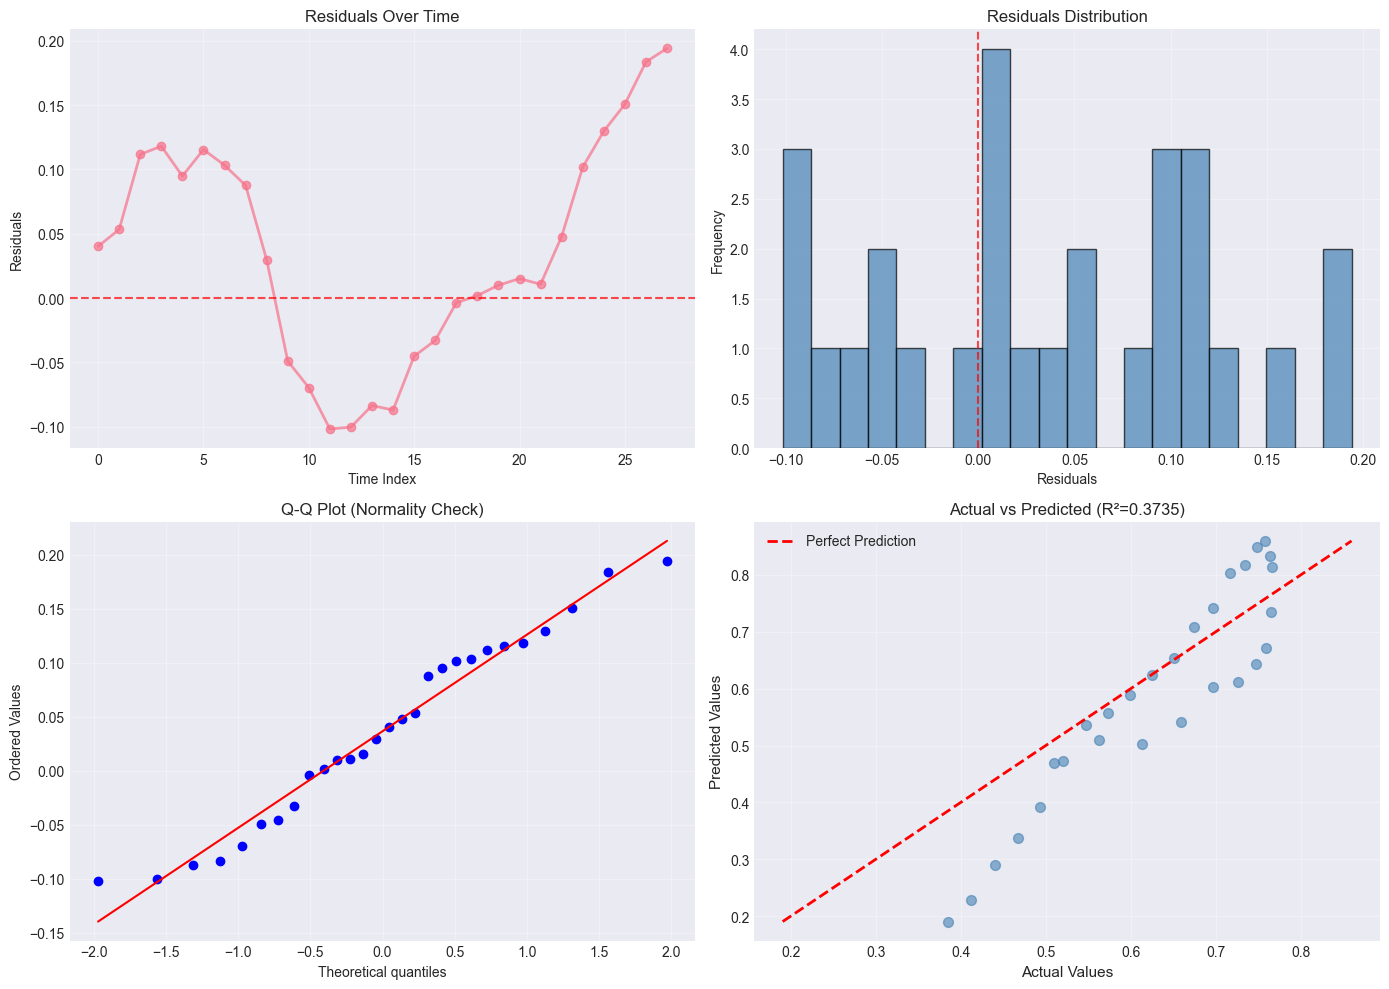


✓ Evaluation completed and visualizations saved!


In [10]:
# Model Evaluation

# Generate predictions
y_pred = best_ridge.predict(X_test_model)

# Calculate metrics
ridge_rmsfe = rmsfe(y_test, y_pred)
ridge_mape = mape(y_test, y_pred)

print("="*70)
print("RIDGE REGRESSION - EVALUATION RESULTS")
print("="*70)
print(f"Model: Ridge Regression (L2 Regularization)")
print(f"Best Alpha: {best_alpha}")
print(f"\nTest Set Performance:")
print(f"  RMSFE: {ridge_rmsfe:.6f}")
print(f"  MAPE:  {ridge_mape:.4f}%")
print("="*70)

# Calculate residuals
residuals = y_test - y_pred

print(f"\nResiduals Summary Statistics:")
print(f"  Mean:     {residuals.mean():.6f}")
print(f"  Std Dev:  {residuals.std():.6f}")
print(f"  Min:      {residuals.min():.6f}")
print(f"  Max:      {residuals.max():.6f}")
print(f"  Median:   {np.median(residuals):.6f}")

# Visualization
from scipy import stats

# Plot 1: Predictions vs Actual
fig = plt.figure(figsize=(14, 6))

# Combine train and test for continuous visualization
plt.plot(range(len(y_train)), y_train, label='Training Data', 
         linewidth=2, alpha=0.7, color='gray')

test_indices = range(len(y_train), len(y_train) + len(y_test))
plt.plot(test_indices, y_test, label='Actual Test Data', 
         linewidth=2, marker='o', markersize=5)
plt.plot(test_indices, y_pred, label='Ridge Predictions', 
         linewidth=2, linestyle='--', marker='s', markersize=5)

plt.axvline(x=len(y_train), color='red', linestyle=':', 
            alpha=0.5, label='Train/Test Split')
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('Core CPI (Standardized)', fontsize=12)
plt.title(f'Ridge Regression: Predictions vs Actual Values\nRMSFE: {ridge_rmsfe:.4f} | MAPE: {ridge_mape:.2f}% | Alpha: {best_alpha}', 
          fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/ridge_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Detailed Diagnostics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals over time
axes[0, 0].plot(residuals, marker='o', linewidth=2, alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_title('Residuals Over Time', fontsize=12)
axes[0, 0].set_xlabel('Time Index')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True, alpha=0.3)

# Residuals histogram
axes[0, 1].hist(residuals, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
axes[0, 1].set_title('Residuals Distribution', fontsize=12)
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# Actual vs Predicted scatter
axes[1, 1].scatter(y_test, y_pred, alpha=0.6, s=50, color='steelblue')
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Values', fontsize=11)
axes[1, 1].set_ylabel('Predicted Values', fontsize=11)
axes[1, 1].set_title(f'Actual vs Predicted (R²={best_ridge.score(X_test_model, y_test):.4f})', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/ridge_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Evaluation completed and visualizations saved!")

In [11]:
# Save Results

# Create results directory if it doesn't exist
os.makedirs('../results/tables', exist_ok=True)
os.makedirs('../results/figures', exist_ok=True)

# Save predictions
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Residual': residuals
})
predictions_df.to_csv('../results/tables/ridge_predictions.csv', index=False)
print("✓ Predictions saved to: ../results/tables/ridge_predictions.csv")

# Save grid search results
grid_results_df = pd.DataFrame({
    'Alpha': results_display['Alpha'],
    'Mean_RMSE': results_display['Mean_RMSE'],
    'Std_RMSE': results_display['Std_RMSE'],
    'Rank': results_display['Rank']
})
grid_results_df.to_csv('../results/tables/ridge_grid_search.csv', index=False)
print("✓ Grid search results saved to: ../results/tables/ridge_grid_search.csv")

# Save feature importance
feature_importance.to_csv('../results/tables/ridge_feature_importance.csv', index=False)
print("✓ Feature importance saved to: ../results/tables/ridge_feature_importance.csv")

# Save metrics summary
metrics_summary = pd.DataFrame({
    'Model': ['Ridge Regression'],
    'RMSFE': [ridge_rmsfe],
    'MAPE': [ridge_mape],
    'Best_Alpha': [best_alpha],
    'CV_RMSE': [-grid_search.best_score_],
    'R2_Score': [best_ridge.score(X_test_model, y_test)],
    'N_Features': [X_train_model.shape[1]],
    'Description': ['L2 regularized linear regression']
})
metrics_summary.to_csv('../results/tables/ridge_metrics.csv', index=False)
print("✓ Metrics summary saved to: ../results/tables/ridge_metrics.csv")

# Print summary
print("\n" + "="*70)
print("RIDGE REGRESSION MODEL SUMMARY")
print("="*70)
print(metrics_summary.to_string(index=False))
print("="*70)

print("\n" + "="*70)
print("MODEL COMPARISON: RIDGE vs BASELINE")
print("="*70)
print("Ridge Regression uses L2 regularization to prevent overfitting by")
print("penalizing large coefficients. Unlike LASSO (L1), Ridge shrinks")
print("coefficients but keeps all features in the model.")
print("\nKey characteristics:")
print("  • Handles multicollinearity well")
print("  • All features retained (no feature selection)")
print("  • Coefficients shrunk towards zero but never exactly zero")
print("  • Good for datasets with many correlated features")
print("="*70)

print("\n✅ Ridge Regression model training and evaluation completed successfully!")
print(f"\nModel Performance Summary:")
print(f"  → RMSFE: {ridge_rmsfe:.6f}")
print(f"  → MAPE: {ridge_mape:.4f}%")
print(f"  → Best Alpha: {best_alpha}")
print(f"  → Number of features used: {X_train.shape[1]}")
print(f"\nAll results saved to ../results/ directory!")

✓ Predictions saved to: ../results/tables/ridge_predictions.csv
✓ Grid search results saved to: ../results/tables/ridge_grid_search.csv
✓ Feature importance saved to: ../results/tables/ridge_feature_importance.csv
✓ Metrics summary saved to: ../results/tables/ridge_metrics.csv

RIDGE REGRESSION MODEL SUMMARY
           Model    RMSFE     MAPE  Best_Alpha  CV_RMSE  R2_Score  N_Features                      Description
Ridge Regression 0.092964 13.69967        50.0 0.089893  0.373544         189 L2 regularized linear regression

MODEL COMPARISON: RIDGE vs BASELINE
Ridge Regression uses L2 regularization to prevent overfitting by
penalizing large coefficients. Unlike LASSO (L1), Ridge shrinks
coefficients but keeps all features in the model.

Key characteristics:
  • Handles multicollinearity well
  • All features retained (no feature selection)
  • Coefficients shrunk towards zero but never exactly zero
  • Good for datasets with many correlated features

✅ Ridge Regression model trainin